In [16]:
2+2

4

## RIVERS-PILOT EXPERIMENT OVERVIEW

    The rivers-pilot project runs the realistic SSC, v201812 (good bloom timing), from the following run directory:
        SS-run-sets/SalishSea/nemo3.6/tereza/RIVERS/RIVERS_pilot
        
    Restarts are from /results/SalishSea/nowcast-green.201812/31dec16
    
    There are two run scenarios, base and SHIFT, which use identical namelist.times and have the following diff patterns per yamls (base v SHIFT):
                < run_id: RP_base_1
            ---
            > run_id: RP_base_1_SHIFT
            20c20
            <     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_R201702/
            ---
            >     link to: $PROJECT/tjarnik/MEOPAR/RIVERS_files/daily_45Dearly/
            54c54
            <   - ./namelist.atmos_rivers
            ---
            >   - ./namelist.atmos_riversSHIFT
            
    The RIVERS_files are made in: 
        notebooks/RIVER_PAPER/RIVERS_pilot/make_daily_files and make_daily_files_shifted_hydrograph
    These use daily interpolated values from monthly averages, for all rivers except the fraser, where realistic 2017 values are used. 
    
    Then we shift the 'glacial' watersheds, as well as the Fraser river, forward 45 days to examine effects. 
        (not the rest of the fraser watershed; this is because Tereza forgot. 
        Not really a problem though, for a pilot run)
    The glacial watersheds are: wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
    
    Results are stored in: /data/tjarniko/results/RIV_PIL
    
## NOTEBOOK OVERVIEW

    1. Here we first visualize the rivers in the SalishSeaCast model by watershed. 
    
    2. We then look at hydrograph patterns by watershed, identifying 
    the largest 5 rivers in each watershed by runoff.
    
    3. We then introduce the river_acid_observatory tool, which shows the hydgrograph of each river of interest 
    as well as key inorg. C cycle variables in the vicinity of its mouth: 
    S, nitrate, diatoms, TA-DIC, DIC, nDIC, and Omega.
    We consider two radii of importance: 3 grid cells from river mouth (~1.5 km) and 10 grid cells (5 km)
    The exception is the Fraser, where we have to consider a point not at the river mouth. 
    
    4. We apply the river_acid_observatory tool to the largest river in each watershed, 
    for both the BASE and the SHIFT runs. 
    
    5. We also build a river_flux_observatory tool, which shows the hydrograph of each river of interest 
    as well as key carbon air-sea flux variables in the vicinity of its mouth:  
    pCO2, delta-pCO2, wind strength, and flux. We apply this to the largest rivers in the watershed as well. 
    

In [17]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [18]:
import sys
import numpy as np
import netCDF4 as nc
import cmocean as cm
import matplotlib.pyplot as plt
import pickle
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import arrow
import gsw
import glob
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')

import river_201702 as rv

## watershed map

In [19]:
def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):
    "TESTED"

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 20 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )
    

    watersheds = rv.prop_dict.keys()
    #watershed counter
    wc = 0
    tr = 0
    wsl = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
    for watshed in watersheds:
        #print(watshed)
        rivs = rv.prop_dict[watshed].keys()
        #river counter for index
        rc = 0
        for riv in rivs:

            ti = rv.prop_dict[watshed][riv]['i']
            tj = rv.prop_dict[watshed][riv]['j']
            if rc==0: 
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],label = wsl[wc],marker='o')
                
            else:
                pts = ax.scatter(tj,ti,s=30,c=cols[wc],marker='o')
                
            ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 10)
            
#             samprivs = ['SanJuan', 'Skagit1', 'Puyallup', 'Nanaimo1', 'Homathko', 'Toba', 'Squamish', 'Englishman'] #samprivs = []
#             if riv in samprivs:
#                 ax.text(tj+5,ti,riv, weight = 'bold', fontsize = 14)

            rc = rc+1
            tr = tr+1
        wc = wc+1
    
    ax.scatter(300,425,s=100,c='k',label = 'Fraser-obs?',marker='*')
   

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cmap.set_bad('lightslategray')
    plt.legend(bbox_to_anchor=(1.29, 0.95))
    plt.suptitle(bigtit,fontsize=20)

In [20]:

watersheds = rv.prop_dict.keys()
riv_i = []
riv_j = []
riv_shed = []
riv_name = []
i = 0
for watshed in watersheds:
    #print('~~')
    rivs = rv.prop_dict[watshed].keys()
    for riv in rivs:
        #print('Riv: '+riv+', watershed: '+watshed)
        #swap is, js here
        ti = rv.prop_dict[watshed][riv]['j']
        tj = rv.prop_dict[watshed][riv]['i']
        riv_i.append(ti)
        riv_j.append(tj)
        riv_shed.append(watshed)
        riv_name.append(riv)
        i = i+1


gauge_riv = ['Squamish','SanJuan','Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene',\
            'Duckabush','Skokomish','DeerJohnsGoldboroughMill','Deschutes','Chambers',\
            'Chambers','NisquallyMcAllister','Puyallup','CedarSammamish','Skagit1',\
            'Samish','Stillaguamish1','SnohomishAllenQuilceda','Tulalip','Mission',\
            'Nooksack','Fraser','Oyster','Qunisam','SalmonSayward','Theodosia',
             'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman',
             'LittleQualicum','Puntledge']

cols = ['darkgray','red','powderblue','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

# Rivers in the SKOG model

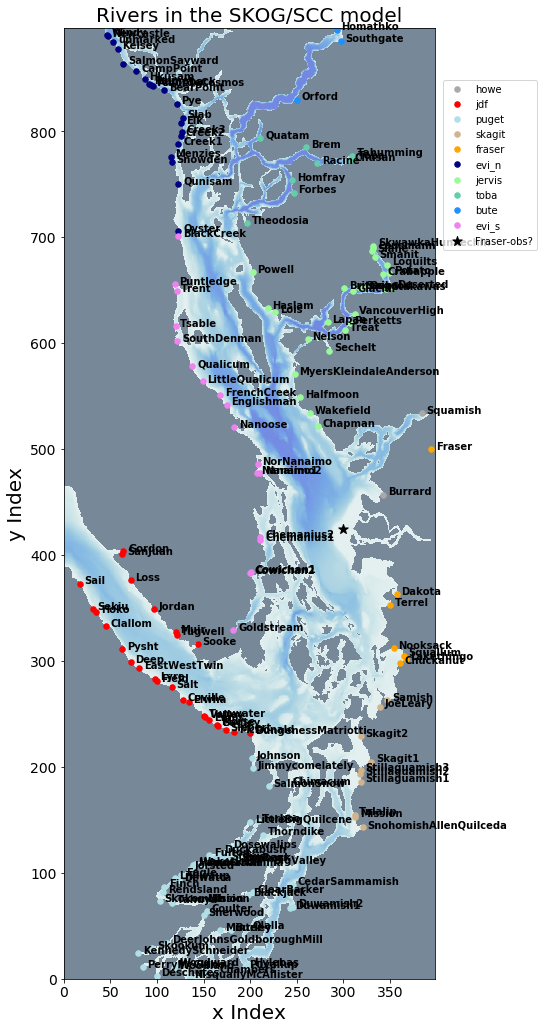

In [21]:
fact = 0.7
bath = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']
wshed_plot(bath1,'Rivers in the SKOG/SCC model', \
               cm.cm.dense,15*fact,25*fact,0,1000,'bathymetry','')

### calculate runoffs

In [22]:
import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')

import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']
for w in watersheds:
    interp_clim = climatology_file[w][:]

    #print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        #print(r)
        prop_wshed = rv.prop_dict[w][r]['prop']
        clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
        river_i = rv.prop_dict[w][r]['j']
        river_j = rv.prop_dict[w][r]['i']
        river_dj = rv.prop_dict[w][r]['di']
        river_di = rv.prop_dict[w][r]['dj']
        area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
        clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
        clim_dict[w][r]['interp_clim_modunits_SHIFT'] = prop_wshed * interp_clim / area * 1000
        if w in wat_to_rot:
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll((prop_wshed * interp_clim / area * 1000),-45) 
        
        
        
        if ((w == 'fraser') & (r == 'Fraser')):
            clim_dict[w][r]['interp_clim_modunits'] = hydroFraser_2017real
            clim_dict[w][r]['interp_clim_modunits_SHIFT'] = np.roll(hydroFraser_2017real,-45)
            
            
            

## watersheds of the model, with 5 largest rivers labeled

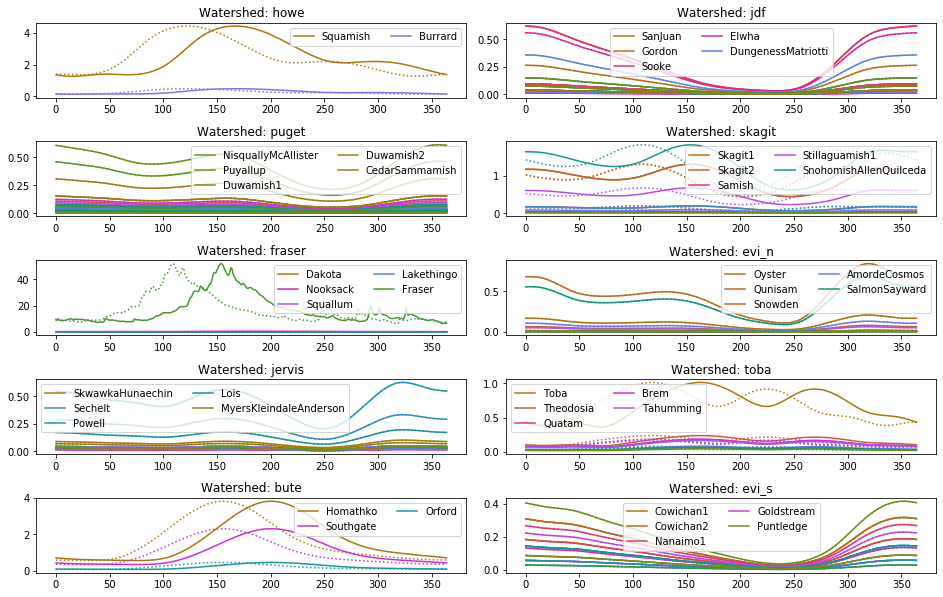

In [23]:
cmap = cm.cm.phase  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#911eb4',\
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',\
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000',\
        '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000',
       'black','mediumseagreen','olivedrab','yellow','saddlebrown']


fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    #print(biggest_riv)
    count = 0 
    numriv = np.size(rivlist)
    for riv in rivs:
        
        if riv in (biggest_riv):
            #yrprop = int((yr-1963) /(2018-1963) * 256)
            #print(int(count/numriv * 256))
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        else:
            ax.plot(clim_dict[w][riv]['interp_clim_modunits'], color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/numriv * 256)], linewidth = 1.5)
        count = count+1
    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)
   

plt.tight_layout()

### watersheds of the model, showing only the top 5 rivers in each watershed

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
skagit
['SnohomishAllenQuilceda' 'Skagit2' 'Skagit1' 'Stillaguamish1' 'Samish']
fraser
['Fraser' 'Nooksack' 'Dakota' 'Lakethingo' 'Squallum']
evi_n
['Qunisam' 'SalmonSayward' 'Oyster' 'AmordeCosmos' 'Snowden']
jervis
['Powell' 'Sechelt' 'Lois' 'SkwawkaHunaechin' 'MyersKleindaleAnderson']
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
bute
['Homathko' 'Southgate' 'Orford']
evi_s
['Puntledge' 'Cowichan1' 'Cowichan2' 'Nanaimo1' 'Goldstream']


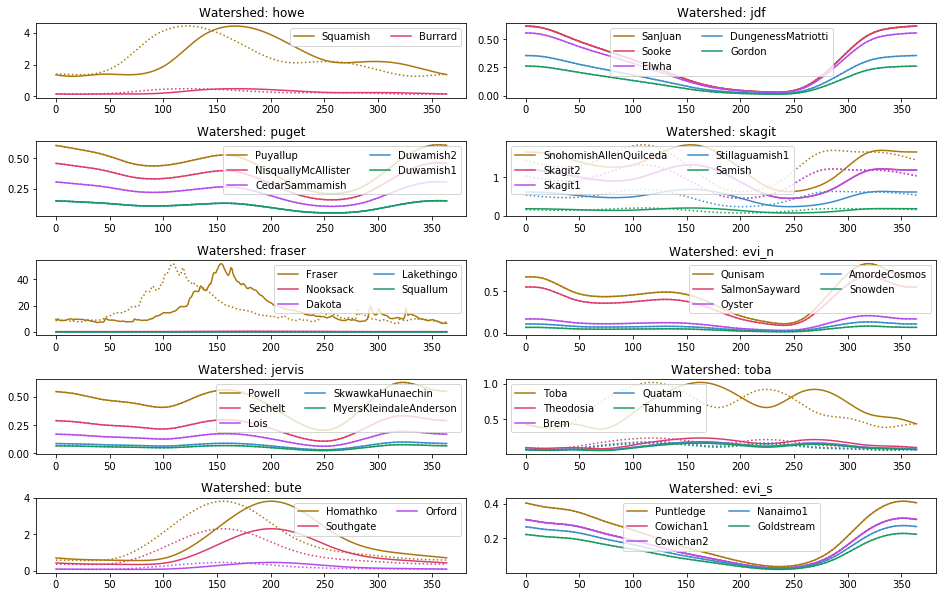

In [24]:
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

fact = 0.6

fig = plt.figure(figsize=(22*fact,14*fact))
for i in range(1,11):
    
    ax = fig.add_subplot(5,2,i)
    w = watersheds[i-1]
    rivs = (clim_dict[w].keys())
        
        #sort rivers highest to smallest and get top 5 rivers, only label those
    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    count = 0
    for riv in biggest_riv:
       
        #if riv in (biggest_riv):
        #print(count)
        #print(int(count/5 * 256))
        ax.plot(clim_dict[w][riv]['interp_clim_modunits'], label = riv, color = cmaplist[int(count/5 * 256)])
        ax.plot(clim_dict[w][riv]['interp_clim_modunits_SHIFT'], linestyle = ':', color = cmaplist[int(count/5 * 256)])
        count = count+1

    ax.legend(ncol = 2, loc = 'best')
    ax.set_title('Watershed: '+ w, fontsize = 12)

plt.tight_layout()

## extraction functions for rivers (extract_ts_BASE and extract_ts_SHIFT)

In [25]:
rv.prop_dict['jdf']['SanJuan']['j']

63

In [26]:
rv.prop_dict['howe']['Squamish']['j']


384

In [27]:
rv.prop_dict['howe']['Squamish']['i']

534

In [28]:
def extract_ts_BASE(start,end,vartyp,varnam,nam,wshed,rad):
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300

    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,0:5,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_SHIFT(start,end,vartyp,varnam,nam,wshed,rad):
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300
    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs//'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,0:5,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_SHIFT_surf(start,end,vartyp,varnam,nam,wshed,rad):
    
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300
        
    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/SHIFT/SHIFT_ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

def extract_ts_BASE_surf(start,end,vartyp,varnam,nam,wshed,rad):
    ti = rv.prop_dict[wshed][nam]['j']
    tj = rv.prop_dict[wshed][nam]['i']
    
    if nam == 'Fraser':
        tj = 425
        ti = 300
    
    start_run = arrow.get(start)
    end_run = arrow.get(end)

    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    #print(dayslen)
    ts = np.zeros(dayslen)
    #print(arrow_array)
    for i in range(0,dayslen):

        tdate = arrow_array[i][0]
        ymd = tdate.format('YYYYMMDD')
        tdir = '/data/tjarniko/results/RIV_PIL/BASE/ncs/'
        guess = 'SalishSeaCast*'+vartyp+'*'+ymd+'.nc'
        w = glob.glob(tdir+guess)
        w = w[0]
        #print(w)
        if i%20 == 0:
            print(ymd)
        tnc = nc.Dataset(w)
        rivmouth = (tnc[varnam][0,tj-rad:tj+rad+1,ti-rad:ti+rad+1])
        rivmouth[rivmouth == 0] = np.nan
        ts[i] = np.nanmean(rivmouth)
    
    return ts

In [29]:
w = nc.Dataset('/data/tjarniko/results/RIV_PIL/BASE/ncs/SalishSeaCast_1d_20170730_20170828_ptrc_T_20170827-20170827.nc')

print(w)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SalishSeaCast_1d_20170730_20170828
    description: biogeochemical variables
    title: biogeochemical variables
    Conventions: CF-1.6
    timeStamp: 2020-Aug-02 07:29:47 GMT
    uuid: e643bc38-cce5-4dd8-ac81-7f87da480545
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 nitrate(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 ammonium(time_counter,deptht,y,x), float32 silicon(time_counter,deptht,y,x), float32 diatoms(time_counter,deptht,y,x), float

### calculate important properties for a given river and store in a dict.


In [30]:
start ='2017-01-01'
end ='2017-12-31'

appendix = '_SHIFT_20170101_20171231'

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
mainrivlist = ['Puyallup','SnohomishAllenQuilceda','Homathko','Toba','Powell','Puntledge','Quinsam']

for w in watersheds:

    rivs = (clim_dict[w].keys())

    rivlist = list(rivs)
    runlist = []

    for riv in rivs:
        maxrun = np.max(clim_dict[w][riv]['interp_clim_modunits'])
        runlist.append(maxrun)

    runar = np.array(runlist)
    rivar = np.array(rivlist)
    inds = runar.argsort()[::-1]
    sortriv = rivar[inds]
    biggest_riv = (sortriv[0:5])
    print(w)
    print(biggest_riv)
    
    for tr in biggest_riv:
        if tr in mainrivlist:
            print(tr)
            pklnam = tr + appendix + '.pkl'
            print(pklnam)
        
            tr_dict = {}
            vartyp = 'grid_T'; varnam = 'vosaline'; rad = 3
            print(varnam)
            tr_dict['sal_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['sal_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)

            vartyp = 'grid_T'; varnam = 'votemper'; rad = 3
            print(varnam)
            tr_dict['temp_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['temp_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)


            vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'; rad = 3
            print(varnam)
            tr_dict['DIC_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['DIC_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)        


            vartyp = 'carp_T'; varnam = 'total_alkalinity'; rad = 3
            print(varnam)
            tr_dict['TA_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['TA_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'diatoms'; rad = 3
            print(varnam)
            tr_dict['diatoms_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['diatoms_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'nitrate'; rad = 3
            print(varnam)
            tr_dict['nitrate_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['nitrate_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

            vartyp = 'ptrc_T'; varnam = 'silicon'; rad = 3
            print(varnam)
            tr_dict['silicon_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['silicon_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 
            
            vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'; rad = 3
            print(varnam)
            tr_dict['co2flux_rad3'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad)
            rad = 10
            tr_dict['co2flux_rad10'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad) 


            pickle.dump(tr_dict, open(pklnam, 'wb'))
        

        
        

howe
['Squamish' 'Burrard']
jdf
['SanJuan' 'Sooke' 'Elwha' 'DungenessMatriotti' 'Gordon']
puget
['Puyallup' 'NisquallyMcAllister' 'CedarSammamish' 'Duwamish2' 'Duwamish1']
Puyallup
Puyallup_SHIFT_20170101_20171231.pkl
vosaline
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
votemper
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
dissolved_inorganic_carbon
20170101
20170121
20170210
20170302
20170322
20170411

20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
silicon
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
co2_flux_mmol_m2_s
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
toba
['Toba' 'Theodosia' 'Brem' 'Quatam' 'Tahumming']
T

20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
diatoms
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
nitrate
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
silicon
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
2017

## calculate spec. for fraser. 

In [31]:
start ='2017-01-01'
end ='2017-12-31'

appendix = '_SHIFT_20170101_20171231'


w = 'fraser'
tr = 'Fraser'

print(tr)
pklnam = tr + appendix + '.pkl'
print(pklnam)

tr_dict = {}
vartyp = 'grid_T'; varnam = 'vosaline'; rad = 3
print(varnam)
tr_dict['sal_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['sal_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)

vartyp = 'grid_T'; varnam = 'votemper'; rad = 3
print(varnam)
tr_dict['temp_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['temp_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)


vartyp = 'carp_T'; varnam = 'dissolved_inorganic_carbon'; rad = 3
print(varnam)
tr_dict['DIC_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['DIC_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)        


vartyp = 'carp_T'; varnam = 'total_alkalinity'; rad = 3
print(varnam)
tr_dict['TA_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['TA_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'diatoms'; rad = 3
print(varnam)
tr_dict['diatoms_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['diatoms_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'nitrate'; rad = 3
print(varnam)
tr_dict['nitrate_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['nitrate_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 

vartyp = 'ptrc_T'; varnam = 'silicon'; rad = 3
print(varnam)
tr_dict['silicon_rad3'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['silicon_rad10'] = extract_ts_SHIFT(start,end,vartyp,varnam,tr,w,rad) 
            
vartyp = 'carp_T'; varnam = 'co2_flux_mmol_m2_s'; rad = 3
print(varnam)
tr_dict['co2flux_rad3'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad)
rad = 10
tr_dict['co2flux_rad10'] = extract_ts_SHIFT_surf(start,end,vartyp,varnam,tr,w,rad) 


pickle.dump(tr_dict, open(pklnam, 'wb'))


        
        

Fraser
Fraser_SHIFT_20170101_20171231.pkl
vosaline
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
votemper
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
dissolved_inorganic_carbon
20170101
20170121
20170210
20170302
20170322
20170411
20170501
20170521
20170610
20170630
20170720
20170809
20170829
20170918
20171008
20171028
20171117
20171207
20171227
20170101
20170121
20170210
20170302
20170322
20170411
2017